In [21]:
%matplotlib inline

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng

from mesa import Agent, Model

'''
Time in most agent-based models moves in steps, sometimes also called ticks. At each step of the model, one or more of the agents – usually all of them – are activated and take their own step, changing internally and/or interacting with one another or the environment.

The scheduler is a special model component which controls the order in which agents are activated.
The RandomActivation scheduler activates all the agents once per step, in random order.
'''
from mesa.time import RandomActivation

'''
Many ABMs have a spatial element, with agents moving around and interacting with nearby neighbors. Mesa currently supports two overall kinds of spaces: grid, and continuous. Grids are divided into cells, and agents can only be on a particular cell, like pieces on a chess board. Continuous space, in contrast, allows agents to have any arbitrary position. Both grids and continuous spaces are frequently toroidal, meaning that the edges wrap around, with cells on the right edge connected to those on the left edge, and the top to the bottom. This prevents some cells having fewer neighbors than others, or agents being able to go off the edge of the environment.

Mesa has two main types of grids: SingleGrid and MultiGrid. SingleGrid enforces at most one agent per cell; MultiGrid allows multiple agents to be in the same cell. Since we want agents to be able to share a cell, we use MultiGrid.
'''
from mesa.space import MultiGrid

'''
The data collector stores three categories of data: model-level variables, agent-level variables, and tables (which are a catch-all for everything else). Model- and agent-level variables are added to the data collector along with a function for collecting them. Model-level collection functions take a model object as an input, while agent-level collection functions take an agent object as an input. Both then return a value computed from the model or each agent at their current state. When the data collector’s collect method is called, with a model object as its argument, it applies each model-level collection function to the model, and stores the results in a dictionary, associating the current value with the current step of the model. Similarly, the method applies each agent-level collection function to each agent currently in the schedule, associating the resulting value with the step of the model, and the agent’s unique_id
'''
from mesa.datacollection import DataCollector

'''
You usually won’t run a model only once, but multiple times, with fixed parameters to find the overall distributions the model generates, and with varying parameters to analyze how they drive the model’s outputs and behaviors. Instead of needing to write nested for-loops for each model, Mesa provides a BatchRunner class which automates it for you.
'''
from mesa.batchrunner import BatchRunner


'''
CanvasGrid works by looping over every cell in a grid, and generating a portrayal for every agent it finds. A portrayal is a dictionary (which can easily be turned into a JSON object) which tells the JavaScript side how to draw it. The only thing we need to provide is a function which takes an agent, and returns a portrayal object. Here’s the simplest one: it’ll draw each agent as a red, filled circle which fills half of each cell.
'''
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer


'''
The basic chart pulls data from the model’s DataCollector, and draws it as a line graph using the Charts.js JavaScript libraries. We instantiate a chart element with a list of series for the chart to track. Each series is defined in a dictionary, and has a Label (which must match the name of a model-level variable collected by the DataCollector) and a Color name. We can also give the chart the name of the DataCollector object in the model.
'''
from mesa.visualization.modules import ChartModule

In [23]:
# De https://github.com/projectmesa/mesa/blob/a44d71ba4b2df0c23c685f6af60cd4b9e5fafffb/examples/wolf_sheep/wolf_sheep/schedule.py

from collections import defaultdict

from mesa.time import RandomActivation


class RandomActivationByBreed(RandomActivation):
    """
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.
    This is equivalent to the NetLogo 'ask breed...' and is generally the
    default behavior for an ABM.
    Assumes that all agents have a step() method.
    """

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_breed = defaultdict(dict)

    def add(self, agent):
        """
        Add an Agent object to the schedule
        Args:
            agent: An Agent to be added to the schedule.
        """

        self._agents[agent.unique_id] = agent
        agent_class = type(agent)
        self.agents_by_breed[agent_class][agent.unique_id] = agent

    def remove(self, agent):
        """
        Remove all instances of a given agent from the schedule.
        """

        del self._agents[agent.unique_id]

        agent_class = type(agent)
        del self.agents_by_breed[agent_class][agent.unique_id]

    def step(self, by_breed=True):
        """
        Executes the step of each agent breed, one at a time, in random order.
        Args:
            by_breed: If True, run all agents of a single breed before running
                      the next one.
        """
        if by_breed:
            for agent_class in self.agents_by_breed:
                self.step_breed(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_breed(self, breed):
        """
        Shuffle order and run all agents of a given breed.
        Args:
            breed: Class object of the breed to run.
        """
        agent_keys = list(self.agents_by_breed[breed].keys())
        self.model.random.shuffle(agent_keys)
        for agent_key in agent_keys:
            self.agents_by_breed[breed][agent_key].step()

    def get_breed_count(self, breed_class):
        """
        Returns the current number of agents of certain breed in the queue.
        """
        return len(self.agents_by_breed[breed_class].values())

In [24]:
class Consumidore(Agent):
    ''' An agent with fixed initial wealth.'''
    def __init__(self, unique_id, model, num_empresas, costo_vida, ingreso_inicial):
        super().__init__(unique_id, model)
        rng = default_rng()
        vals = rng.uniform()

        # Dotaciones iniciales
        # self.theta = 1 / num_empresas
        self.costo_vida = costo_vida
        self.oferta_trabajo_inicial = round(vals, 2)
        self.ingreso_inicial = ingreso_inicial
        self.oferta_trabajo_disponible = self.oferta_trabajo_inicial
        self.ingreso_total = self.ingreso_inicial
        self.ingreso_disponible = self.ingreso_inicial
        self.factor_descanso = round(default_rng().uniform(), 2)
        self.delta_oferta_trabajo = round(default_rng().uniform(0, 1 - self.oferta_trabajo_disponible), 2)
        # Temporal
        self.demanda_trabajo_disponible = round(default_rng().uniform(0, 5), 2)

    def cambio_oferta_trabajo(self):
        camaradas = self.model.schedule.agents

        if len(camaradas) > 1:
            otre = self.random.choice(camaradas)

            if (otre.delta_oferta_trabajo + oferta_trabajo) <= 1:
                self.delta_oferta_trabajo = otre.delta_oferta_trabajo
    
    def trabaja(self):
        camaradas = self.model.schedule.agents
        
        for i in range(len(camaradas)):
            otre = camaradas[i]
            oferta = self.oferta_trabajo_disponible
    
            if self.oferta_trabajo_disponible > 0 and otre.demanda_trabajo_disponible > 0:
                oferta = round(default_rng().uniform(0, self.oferta_trabajo_disponible), 2)

            salario = 100 * oferta
            self.oferta_trabajo_disponible -= oferta
            self.ingreso_disponible += salario
            self.ingreso_total += salario
            otre.demanda_trabajo_disponible -= oferta
    
    def consume(self):
        if self.ingreso_disponible - self.costo_vida > 0:
            placeres = round(default_rng().uniform(0, self.ingreso_disponible - self.costo_vida), 2)
            # Si se gastan todo su dinero disponible para los placeres, algo no jala
            # placeres = self.ingreso_disponible
            self.ingreso_disponible -= placeres
    
    def descansa(self):
        self.oferta_trabajo_disponible = self.factor_descanso * self.oferta_trabajo_inicial
        self.factor_descanso = round(default_rng().uniform(), 2)

    def step(self):
        # Si los ingresos del consumidore son menores a los costos de vivir, muere
        if self.ingreso_disponible < self.costo_vida:
            self.model.schedule.remove(self)

        self.trabaja()
        self.consume()
        self.descansa()


class Empresa(Agent):
    ''' An agent with fixed initial wealth.'''
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class EconomiSocialista(Model):
    costo_vida = 40
    ingreso_inicial = 40

    '''A model with some number of agents.'''
    def __init__(self, I, J):
        self.num_consumidores = I
        self.num_empresas = J
        self.schedule = RandomActivationByBreed(self)
        self.running = True

        # Create agents
        for i in range(self.num_consumidores):
            a = Consumidore(i, self, J, self.costo_vida, self.ingreso_inicial)
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

99995, 284.35999999999996, 423.67999999999995, 61.16, 190.39, 367.5, 294.49, 209.93999999999997, 346.54, 390.9, 441.14, 258.49999999999994, 490.44999999999993, 56.86, 381.22, 157.12, 492.59999999999997, 512.14, 525.76, 290.2, 102.04, 427.89, 402.05, 500.02, 55.92999999999999, 117.85999999999999, 387.7300000000001, 304.96, 88.96, 163.28, 332.5, 485.5, 149.68000000000004, 40.0, 253.77999999999994, 101.91999999999999, 97.98000000000002, 509.03, 562.72, 352.89000000000004, 401.76, 143.84, 697.72, 187.22, 284.86, 165.37, 135.39999999999998, 240.0, 101.28, 356.66, 105.88, 416.65999999999997, 92.9, 676.57, 249.88, 339.64, 242.8, 341.23999999999995, 512.23, 513.86, 332.0300000000001, 548.2800000000001, 271.23999999999995, 46.9, 479.74, 386.49999999999994, 401.3399999999999, 198.4, 175.8, 571.36, 335.2, 424.8, 128.32, 508.51, 105.1, 167.2, 60.75, 270.34000000000003, 401.76, 417.6, 684.84, 478.6999999999999, 246.64, 389.68, 146.08, 49.70000000000001, 316.57, 249.76000000000002, 538.08, 176.8, 90

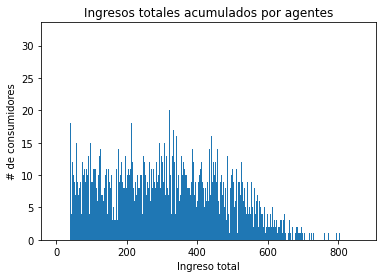

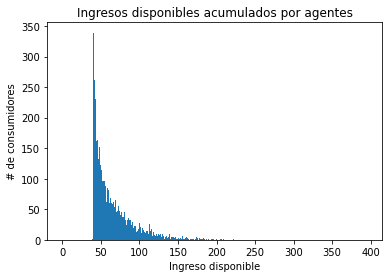

In [25]:
ingresos_totales = []
ingresos = []

for j in range(100):
    # Run the model
    model = EconomiSocialista(50, 0)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        ingresos_totales.append(agent.ingreso_total)
        print(agent.ingreso_total)
        ingresos.append(agent.ingreso_disponible)

print(ingresos)
print(ingresos_totales)

plt.xlabel('Ingreso total')
plt.ylabel('# de consumidores')
plt.title('Ingresos totales acumulados por agentes')
plt.hist(ingresos_totales, bins=range(int(max(ingresos_totales))+1))
plt.show()

plt.xlabel('Ingreso disponible')
plt.ylabel('# de consumidores')
plt.title('Ingresos disponibles acumulados por agentes')
plt.hist(ingresos, bins=range(int(max(ingresos))+1))
plt.show()